In [1]:
import nibabel as nib
import h5py
import os.path as op
import copy
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

ModuleNotFoundError: No module named 'sklearn'

In [2]:
subject = 'subj01'

nsd_folder = '../data/nsd'
nsddata_folder = op.join(nsd_folder, 'nsddata')
ppdata_folder = op.join(nsd_folder, 'nsddata', 'ppdata')
nsddata_betas_folder = op.join(nsd_folder, 'nsddata_betas', 'ppdata')
behavior_file = op.join(ppdata_folder, '{subject}', 'behav', 'responses.tsv')
stimuli_file = op.join(nsd_folder, 'nsddata_stimuli', 'stimuli', 'nsd', 'nsd_stimuli.hdf5')
stimuli_description_file = op.join(nsd_folder, 'nsddata', 'experiments', 'nsd', 'nsd_stim_info_merged.csv')
coco_annotation_file = op.join(nsd_folder, 'nsddata_stimuli', 'stimuli', 'nsd', 'annotations', '{}_{}.json')

data_format = 'func1pt8mm'
subj = subject
data_type='betas_fithrf_GLMdenoise_RR'

data_folder = op.join(nsddata_betas_folder, subject, data_format, data_type)

# Load roi

file = op.join(ppdata_folder, f"{subject}/{data_format}/roi/nsdgeneral.nii.gz")
nifti = nib.load(file) 
mask = nifti.get_fdata()
mask[mask<1] = 0 
nsdgeneral_mask = mask
nsdgeneral_mask.shape

In [ ]:
def read_behavior(subject, session_index, trial_index=[]):
    behavior = pd.read_csv(behavior_file.format(subject=subject), delimiter='\t')
    session_behavior = behavior[behavior['SESSION'] == session_index]
    if len(trial_index) == 0:
        trial_index = slice(0, len(session_behavior))
    return session_behavior.iloc[trial_index]
    
def read_betas(subject, session_index, trial_index=[], data_type='betas_fithrf_GLMdenoise_RR', data_format='fsaverage', mask=None):
    data_folder = op.join(nsddata_betas_folder, subject, data_format, data_type)
    si_str = str(session_index).zfill(2)
    # if no mask was specified, we'll use the nifti image
    ipf = op.join(data_folder, f'betas_session{si_str}.hdf5')
    h5 = h5py.File(ipf, 'r')
    betas = h5.get('betas')
    # out_data = nb.load(
    #     op.join(data_folder, f'betas_session{si_str}.nii.gz')).get_data()
    if len(trial_index) == 0:
        # trial_index = slice(0, out_data.shape[-1])
        trial_index = slice(0, betas.shape[0])
    return betas[trial_index,:]

def normalize(x, mean=None, std=None):
    mean = np.mean(x) if mean is None else mean
    std = np.std(x) if std is None else std
    return (x - mean) / (std * 1.0)

# Preprocessing fMRI

In [ ]:
# How many sessions do you want to read
nsessions = 40
patch_size = 16

In [ ]:
for tar in tqdm(range(nsessions)):
    sess=tar+1
    
    behav = read_behavior(subject=subject, 
                session_index=sess, 
                trial_index=[]) 

    # pull single-trial betas and mask them
    betas = read_betas(subject=subject, 
                        session_index=sess, 
                        trial_index=[], # empty list as index means get all for this session
                        data_type='betas_fithrf_GLMdenoise_RR', # GLMSingle beta2
                        data_format='func1pt8mm') 

    # betas = betas[mask]
    # betas = np.moveaxis(betas,-1,0)
    
    vox_include = copy.deepcopy(nsdgeneral_mask)

    ncsnr_dir = op.join(data_folder, f'ncsnr.nii.gz')
    ncsnr = nib.load(ncsnr_dir).get_fdata()
    ncsnr[ncsnr<.15] = np.nan 

    if tar==0: print("voxels left:", len(vox_include[vox_include>0]))
    # Subtract 1 from the values ​​in vox_include that correspond to the positions in ncsnr that are np.nan
    vox_include[np.isnan(ncsnr)] -= 1 # keep all nsdgeneral voxels even if they are below the threshold
    vox_include[vox_include<0] = 0
    # This helps keep track of how many voxels are still included after thresholding
    if tar==0: print("voxels left after ncsnr thresholding:", len(vox_include[vox_include>0])) # subj01 = 49329
    
    betas = betas.reshape(len(betas),-1)
    betas = betas[:,vox_include.flatten().astype(bool)]
    shape = betas.shape

    # padding to multiples of 16 to facilitate subsequent training
    patch_size = 16
    betas_pad = np.pad(betas, ((0,0),(0, patch_size-betas.shape[1]%patch_size)), 'wrap')

    # normalization
    betas_norm = normalize(betas_pad)
    
    globals()[f'betas_ses{sess}'] = betas_norm  
    globals()[f'behav_ses{sess}'] = behav   
    print(betas_norm.shape)

# Save npy file

In [ ]:
# Merge betas arrays from different sessions
for tar in range(nsessions):
    sess=tar+1
    if sess==1:
        betas_all = globals()[f'betas_ses{sess}']
    else:
        betas_all = np.vstack((betas_all,globals()[f'betas_ses{sess}']))
    print(betas_all.shape)

In [ ]:
np.save(f"./betas_{subject}.npy", betas_all)
print(f"saved betas_{subject}.npy")

merge all the npy files

In [3]:
import numpy as np
import os.path as op

npy_dir = '/root/autodl-tmp/.autodl/Projects/fMRI2TextAligner/data/nsd'

In [5]:
import numpy as np
from tqdm import tqdm

# Initialize an empty array to store the merged data
merged_data = None

# Traverse the file names from 01 to 10
for i in tqdm(range(1, 11), desc='Merging files', unit='file'):
    # Format file name
    filename = op.join(npy_dir, f'betas_subj01_batch{i:02d}.npy')
    
    # Load npy file
    with open(filename, 'rb') as f:
        data = np.load(f)
    
    # If it is the first file, initialize merged_data
    if merged_data is None:
        merged_data = data
    else:
        # Otherwise, merge the current data along the first dimension (batch)
        merged_data = np.concatenate((merged_data, data), axis=0)
    del data

# Save the merged data to a new npy file

np.save(op.join(npy_dir, 'merged_betas_subj01_all.npy'), merged_data)

del merged_data

print('Merged data saved to merged_betas_subj01.npy')

Merging files: 100%|██████████| 10/10 [00:11<00:00,  1.18s/file]


Merged data saved to merged_betas_subj01.npy


# read the npy file

In [6]:
npy_all = np.load(op.join(npy_dir, 'merged_betas_subj01_all.npy'))
npy_all.shape

(30000, 13888)

Text(0, 0.5, 'Value')

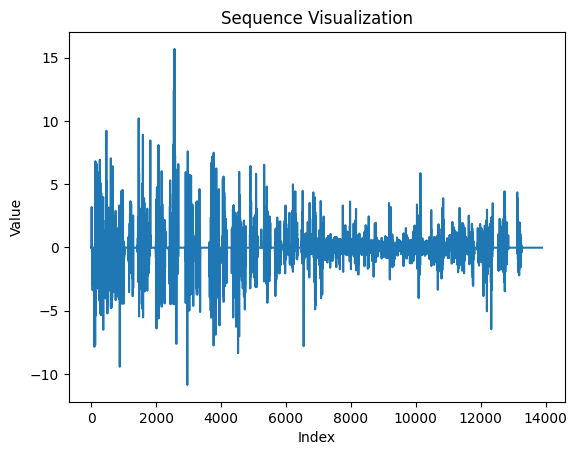

In [8]:
import matplotlib.pyplot as plt
x_values = list(range(len(npy_all[0])))
plt.plot(x_values, npy_all[0])

plt.title("Sequence Visualization")
plt.xlabel("Index")
plt.ylabel("Value")

Text(0, 0.5, 'Value')

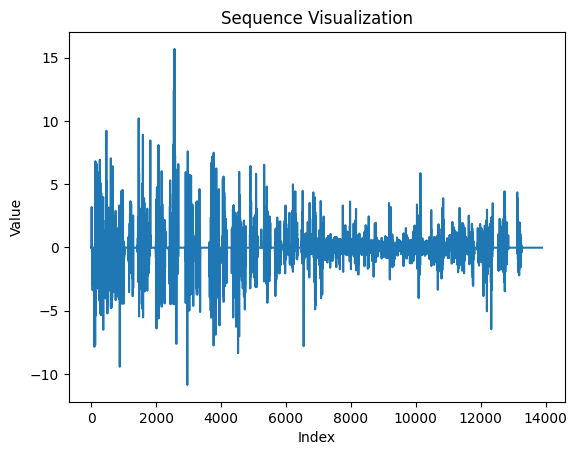

In [10]:
npy_batch01 = np.load(op.join(npy_dir, 'betas_subj01_batch01.npy'))
npy_batch01.shape

x_values = list(range(len(npy_batch01[0])))
plt.plot(x_values, npy_batch01[0])

plt.title("Sequence Visualization")
plt.xlabel("Index")
plt.ylabel("Value")